# What makes a good predictor of home prices?

In [98]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [99]:
# Read in cleaned Kings County file 
df = pd.read_csv("cleaned_kings.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

## Evaluate outliers
It seems there are very few highly priced homes that would negatively impact a prediction model. Let's take out the top priced homes for a representative model. According to the box plot below we have significant outliers.

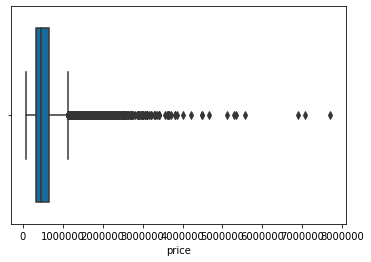

In [5]:
# Create boxplot for price
sns.boxplot(x='price', data=df);

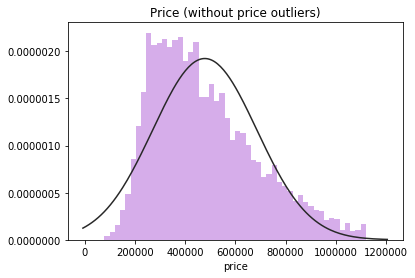

20268 21420
Number of homes excluded is 1152
Reduced homes by 5%


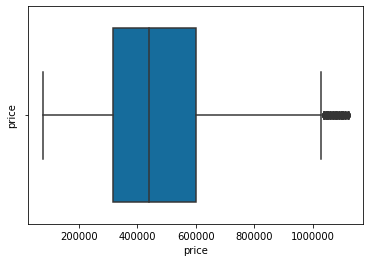

In [6]:
# Calculate the price limit for outliers using 1.5 * IQR + Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limit = 1.5 * IQR + Q3
limit

# Remove upper outliers from sqft_lot and create histogram again
df_price = df[df['price'] < limit]

# Histogram (distplot)
sns.distplot(df_price['price'], color='darkorchid', label=df_price, fit=norm, kde=False)
plt.title('Price (without price outliers)')
plt.show()
print(len(df_price), len(df))
print('Number of homes excluded is ' + str(len(df) - len(df_price)))
print('Reduced homes by ' + str(round(100 - len(df_price) / len(df) * 100)) + '%')

sns.scatterplot(x="zipcode", y="price", data=df_price)
sns.boxplot(x='price', data=df_price);

The histogram and box plot above show a more normal set of data values for us to evaluate. Let's now use pairwise plots between our given conditions and price to see if there are any linear relationships to explore.

## A check for linear relationships

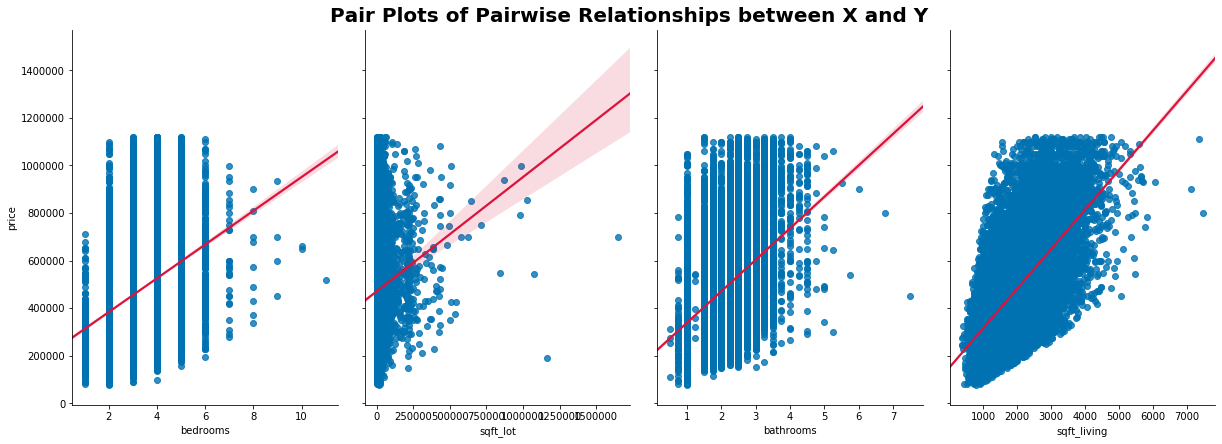

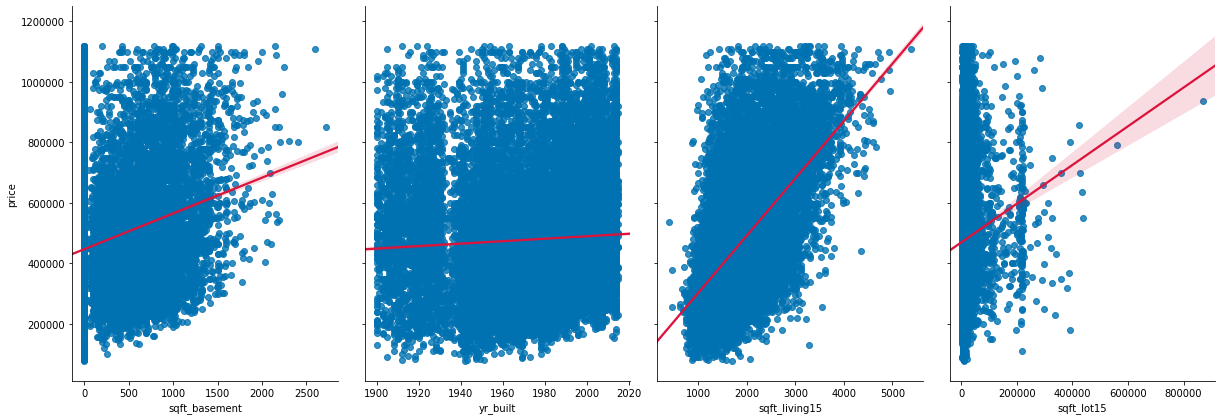

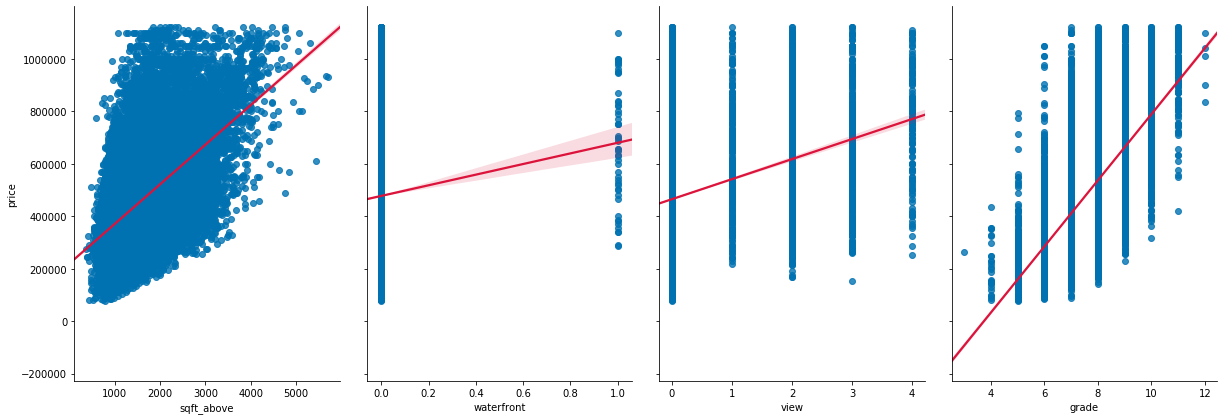

In [7]:
# visualize the pairwise relationship between the features and the response using pairplots 

sns.pairplot(x_vars=['bedrooms', 'sqft_lot', 'bathrooms', 'sqft_living'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)

plt.suptitle('Pair Plots of Pairwise Relationships between X and Y', size=20, weight='bold', y=1.02)

sns.pairplot(x_vars=['sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
sns.pairplot(x_vars=['sqft_above', 'waterfront', 'view', 'grade'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
plt.show();

A few of the graphs seem to have a good linear relationship: bedrooms, bathrooms, sqft_living, sqft_living15, sqft_above, and grade. After checking for normalcy, let's evaluate these relationships.

## A check for normalcy

In [95]:
# First well limit our set to the indicated features
data = df_price[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 'sqft_above', 'grade']]


In [96]:
data.head()

In [85]:
# Create a loop to display all the histograms
for item in data:
    sns.distplot(df[item], color='pink', label=item, fit=norm, kde=False)
    plt.title(item)
    plt.legend()
    plt.show()

All features seem relatively normal except bathrooms. 

## Let's check for any type of correlation

In [86]:
# heatmap to show relationships
plt.figure(figsize=(8,6))
sns.heatmap(data.corr().abs(), annot=True, cmap='YlGnBu')
plt.autoscale()
plt.show()

In [87]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [88]:
X = data.drop(columns=['price'])
y = pd.DataFrame(data.price, columns= ['price'])

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

The highest correlating factors with price are grade and sqft_living. Here bedrooms also shows a low correlation so I will remove bedrooms as an evaluation feature.

In [89]:
data = data.drop(['bedrooms'], axis=1)
data.head(2)

## Create an OLS regression model to evaluate features
### Individual Regression Comparisons

In [90]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
for feature in data:
    d = {}
    formula_str = 'price ~ ' + str(feature)
    res = ols(formula=formula_str, data=data).fit()
    # Make a summary chart
    d['feature'] = feature
    d['intcept'], d['t'] = res.tvalues
    d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
    d['r2'] = res.rsquared
    summaries.append(d)
    res.summary()

In [91]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df

### Regress Step 2
Using the a stepwise approach. I will select the feature from the first level evaluation with the highest t-value, <b>grade</b>, to continue to evaluate features.

In [92]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
for item in data:
    formula_str = 'price ~ grade + ' + str(item)
    d = {}
    res = ols(formula=formula_str, data=data).fit()
    d['feature'] = item
    d['intcept'], d['t'] = res.tvalues
    d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
    d['r2'] = res.rsquared
    summaries.append(d)
    res.summary()

In [93]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
formula_str = 'price ~ grade + bathrooms'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'bathrooms'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living15'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living15'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_above'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_above'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

In [94]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df.head()

Price with grade and sqft_living have the highest r-squared value, the highest t-value, and the lowest Jarque-Bera

In [18]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
formula_str = 'price ~ grade + sqft_living + bathrooms'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'bathrooms'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living + sqft_living15'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living15'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living + sqft_above'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_above'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     5771.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        07:52:27   Log-Likelihood:            -2.7063e+05
No. Observations:               20268   AIC:                         5.413e+05
Df Residuals:                   20264   BIC:                         5.413e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.859e+05   8775.437    -32.576      0.000   -3.03e+05   -2.69e+05
grade        7.946e+04   1494.152     53.183      0.000    7.65e+04    8.24e+04
sqft_living   104.8995      2.260     46.424      0.000     100.470     109.328
bathrooms   -2.059e+04   2214.606     -9.297      0.000   -2.49e+04   -1.62e+04
==============================================================================
Omnibus:                     1169.561   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1410.011
Skew:                           0.595   Prob(JB):                    6.61e-307
Kurtosis:                       3.504   Cond. No.                     1.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     5834.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        07:52:27   Log-Likelihood:            -2.7058e+05
No. Observations:               20268   AIC:                         5.412e+05
Df Residuals:                   20264   BIC:                         5.412e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.749e+05   8777.442    -31.316      0.000   -2.92e+05   -2.58e+05
grade          6.976e+04   1532.549     45.520      0.000    6.68e+04    7.28e+04
sqft_living      78.6735      2.250     34.964      0.000      74.263      83.084
sqft_living15    37.2676      2.712     13.743      0.000      31.953      42.583
==============================================================================
Omnibus:                     1139.517   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1356.167
Skew:                           0.594   Prob(JB):                    3.25e-295
Kurtosis:                       3.440   Cond. No.                     2.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     5887.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        07:52:27   Log-Likelihood:            -2.7054e+05
No. Observations:               20268   AIC:                         5.411e+05
Df Residuals:                   20264   BIC:                         5.411e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.199e+05   8996.246    -35.563      0.000   -3.38e+05   -3.02e+05
grade        8.379e+04   1517.808     55.207      0.000    8.08e+04    8.68e+04
sqft_living   126.3458      2.740     46.104      0.000     120.974     131.717
sqft_above    -48.6850      2.938    -16.572      0.000     -54.443     -42.927
==============================================================================
Omnibus:                     1127.650   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1358.902
Skew:                           0.579   Prob(JB):                    8.28e-296
Kurtosis:                       3.520   Cond. No.                     2.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df.head()

# sqft_living: 
# int -32.318928 tg 52.310300 tf1 48.278051 jb 1424.481869 p 4.760936e-310
# sk 0.602770 kurt 3.483167 r2 0.458443

,feature,intcept,tg,tf1,tf2,jb,p,sk,kurt,r2
0,bathrooms,-32.575719,53.18281,46.423808,-9.296813,1410.011111,6.606594e-307,0.594985,3.503599,0.460743
1,sqft_living15,-31.316257,45.51974,34.964116,13.743453,1356.167351,3.250883e-295,0.594177,3.440112,0.463444
2,sqft_above,-35.563175,55.20682,46.104358,-16.572051,1358.902002,8.282843e-296,0.578522,3.519970,0.465684


the higher t-value and r-squared value comes from sqft_above and it is higher than the previous. The Jarque-Bera value is also lower. So I will sqft_above and evaluate it with sqft_living15 and bathrooms. 

In [40]:
# Create the OLS model by looping through each feature and create a summary table
formula_str = 'price ~ grade + sqft_living + sqft_above + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

# Create the OLS model by looping through each feature and create a summary table
formula_str = 'price ~ grade + sqft_living + sqft_above + bathrooms'
res = ols(formula=formula_str, data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     4551.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:42:52   Log-Likelihood:            -2.7040e+05
No. Observations:               20268   AIC:                         5.408e+05
Df Residuals:                   20263   BIC:                         5.408e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.148e+05   8937.828    -35.223      0.000   -3.32e+05   -2.97e+05
grade          7.683e+04   1561.643     49.196      0.000    7.38e+04    7.99e+04
sqft_living     112.6907      2.837     39.725      0.000     107.130     118.251
sqft_above      -57.4481      2.962    -19.394      0.000     -63.254     -51.642
sqft_living15    46.4608      2.728     17.029      0.000      41.113      51.809
==============================================================================
Omnibus:                     1071.211   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1274.259
Skew:                           0.566   Prob(JB):                    1.99e-277
Kurtosis:                       3.478   Cond. No.                     2.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     4455.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:42:53   Log-Likelihood:            -2.7050e+05
No. Observations:               20268   AIC:                         5.410e+05
Df Residuals:                   20263   BIC:                         5.410e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.214e+05   8979.211    -35.798      0.000   -3.39e+05   -3.04e+05
grade        8.675e+04   1548.443     56.026      0.000    8.37e+04    8.98e+04
sqft_living   136.6438      2.955     46.245      0.000     130.852     142.435
sqft_above    -48.4325      2.932    -16.519      0.000     -54.179     -42.686
bathrooms   -2.025e+04   2199.993     -9.204      0.000   -2.46e+04   -1.59e+04
==============================================================================
Omnibus:                     1107.125   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1338.231
Skew:                           0.568   Prob(JB):                    2.55e-291
Kurtosis:                       3.541   Cond. No.                     2.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

sqft_living15 adds value so I will try all features.

In [41]:
# Create the OLS model with all features to compare
formula_str = 'price ~ grade + sqft_living + sqft_above + bathrooms + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     3664.
Date:                Mon, 17 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:53:39   Log-Likelihood:            -2.7036e+05
No. Observations:               20268   AIC:                         5.407e+05
Df Residuals:                   20262   BIC:                         5.408e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.163e+05   8926.079    -35.436      0.000   -3.34e+05   -2.99e+05
grade          7.963e+04   1598.609     49.812      0.000    7.65e+04    8.28e+04
sqft_living     122.0587      3.068     39.790      0.000     116.046     128.071
sqft_above      -56.9097      2.958    -19.237      0.000     -62.708     -51.111
bathrooms     -1.744e+04   2192.357     -7.953      0.000   -2.17e+04   -1.31e+04
sqft_living15    44.7588      2.733     16.380      0.000      39.403      50.115
==============================================================================
Omnibus:                     1062.513   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1268.196
Skew:                           0.560   Prob(JB):                    4.12e-276
Kurtosis:                       3.499   Cond. No.                     2.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Due to the high Condition and Jarque-Bera I suspect we have collinearity. Since grade is actually categorical data I will change it to a category and create dummy variables to properly assess it's predictive value.

## Grade to Category for Regression Comparison

In [52]:
# Change grade to a category
data.grade = data.grade.astype('int')
data.grade.describe()

count    20268.000000
mean         7.535573
std          1.035115
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: grade, dtype: float64

In [54]:
# Create bins
bins = [3,4,5,6,7,8,9,10,11,12]

# Use pd.cut()
bins_grade = pd.cut(data['grade'], bins)

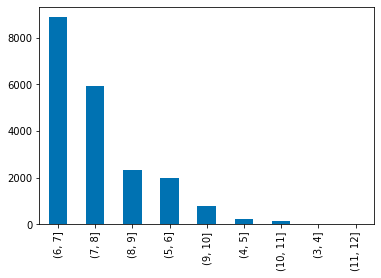

In [56]:
bins_grade = bins_grade.cat.as_ordered()
bins_grade.value_counts().plot(kind='bar')

In [57]:
# Replace existing 'grade' column
data['grade'] = bins_grade

In [58]:
# Remove first column and add new dummy variables to data
grade_dummies = pd.get_dummies(bins_grade, prefix='grade', drop_first=True)

In [61]:
# Create dummy variables for grade column
data = pd.concat([data, grade_dummies], axis=1)
data

,price,bathrooms,sqft_living,sqft_living15,sqft_above,grade,"grade_(4, 5]","grade_(5, 6]","grade_(6, 7]","grade_(7, 8]","grade_(8, 9]","grade_(9, 10]","grade_(10, 11]","grade_(11, 12]"
0,221900.0,1.00,1180,1340,1180,"(6, 7]",0,0,1,0,0,0,0,0
1,538000.0,2.25,2570,1690,2170,"(6, 7]",0,0,1,0,0,0,0,0
2,180000.0,1.00,770,2720,770,"(5, 6]",0,1,0,0,0,0,0,0
3,604000.0,3.00,1960,1360,1050,"(6, 7]",0,0,1,0,0,0,0,0
4,510000.0,2.00,1680,1800,1680,"(7, 8]",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,360000.0,2.50,1530,1530,1530,"(7, 8]",0,0,0,1,0,0,0,0
21416,400000.0,2.50,2310,1830,2310,"(7, 8]",0,0,0,1,0,0,0,0
21417,402101.0,0.75,1020,1020,1020,"(6, 7]",0,0,1,0,0,0,0,0
21418,400000.0,2.50,1600,1410,1600,"(7, 8]",0,0,0,1,0,0,0,0


In [45]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20268 entries, 0 to 21419
Data columns (total 15 columns):
price            20268 non-null float64
bathrooms        20268 non-null float64
sqft_living      20268 non-null int64
sqft_living15    20268 non-null int64
sqft_above       20268 non-null int64
grade            20268 non-null category
grade_4          20268 non-null uint8
grade_5          20268 non-null uint8
grade_6          20268 non-null uint8
grade_7          20268 non-null uint8
grade_8          20268 non-null uint8
grade_9          20268 non-null uint8
grade_10         20268 non-null uint8
grade_11         20268 non-null uint8
grade_12         20268 non-null uint8
dtypes: category(1), float64(2), int64(3), uint8(9)
memory usage: 1.1 MB


In [62]:
# 
formula_str = 'price ~ sqft_living + sqft_above + bathrooms + sqft_living15 + grade_11 + grade_12 + grade_4 + grade_5 + grade_6 + grade_7 + grade_8 + grade_9 + grade_10'
res = ols(formula=formula_str, data=c_data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     1433.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:47:35   Log-Likelihood:            -2.7028e+05
No. Observations:               20268   AIC:                         5.406e+05
Df Residuals:                   20254   BIC:                         5.407e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.864e+05    1.5e+05      1.244      0.214   -1.07e+05     4.8e+05
sqft_living     123.5868      3.062     40.358      0.000     117.585     129.589
sqft_above      -62.6326      2.990    -20.946      0.000     -68.494     -56.772
bathrooms      -1.41e+04   2239.167     -6.297      0.000   -1.85e+04   -9710.125
sqft_living15    40.6926      2.744     14.830      0.000      35.314      46.071
grade_11        3.91e+05   1.51e+05      2.598      0.009     9.6e+04    6.86e+05
grade_12       3.648e+05   1.64e+05      2.220      0.026    4.27e+04    6.87e+05
grade_4       -6.401e+04   1.53e+05     -0.420      0.675   -3.63e+05    2.35e+05
grade_5       -3.883e+04    1.5e+05     -0.259      0.796   -3.33e+05    2.55e+05
grade_6       -1848.5205    1.5e+05     -0.012      0.990   -2.95e+05    2.92e+05
grade_7          5.3e+04    1.5e+05      0.354      0.723   -2.41e+05    3.47e+05
grade_8        1.372e+05    1.5e+05      0.916      0.360   -1.56e+05    4.31e+05
grade_9        2.447e+05    1.5e+05      1.633      0.103   -4.91e+04    5.38e+05
grade_10       3.177e+05    1.5e+05      2.118      0.034    2.37e+04    6.12e+05
==============================================================================
Omnibus:                     1134.861   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1387.007
Skew:                           0.572   Prob(JB):                    6.53e-302
Kurtosis:                       3.579   Cond. No.                     1.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
# 
formula_str = 'price ~ sqft_living + sqft_above + bathrooms + grade_11 + grade_12 + grade_4 + grade_5 + grade_6 + grade_7 + grade_8 + grade_9 + grade_10'
res = ols(formula=formula_str, data=c_data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     1518.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:48:18   Log-Likelihood:            -2.7039e+05
No. Observations:               20268   AIC:                         5.408e+05
Df Residuals:                   20255   BIC:                         5.409e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     2.32e+05   1.51e+05      1.541      0.123   -6.31e+04    5.27e+05
sqft_living   136.8397      2.945     46.470      0.000     131.068     142.612
sqft_above    -55.8350      2.971    -18.795      0.000     -61.658     -50.012
bathrooms   -1.618e+04   2246.819     -7.200      0.000   -2.06e+04   -1.18e+04
grade_11     4.186e+05   1.51e+05      2.767      0.006    1.22e+05    7.15e+05
grade_12     3.857e+05   1.65e+05      2.335      0.020    6.19e+04     7.1e+05
grade_4     -6.089e+04   1.53e+05     -0.397      0.691   -3.61e+05     2.4e+05
grade_5     -4.547e+04   1.51e+05     -0.301      0.763   -3.41e+05     2.5e+05
grade_6     -1.148e+04   1.51e+05     -0.076      0.939   -3.07e+05    2.84e+05
grade_7       4.75e+04   1.51e+05      0.315      0.752   -2.48e+05    3.43e+05
grade_8      1.386e+05   1.51e+05      0.920      0.358   -1.57e+05    4.34e+05
grade_9      2.553e+05   1.51e+05      1.694      0.090   -4.01e+04    5.51e+05
grade_10     3.356e+05   1.51e+05      2.226      0.026       4e+04    6.31e+05
==============================================================================
Omnibus:                     1192.008   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1483.646
Skew:                           0.582   Prob(JB):                         0.00
Kurtosis:                       3.634   Cond. No.                     1.27e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
# 
formula_str = 'price ~ sqft_living + grade_11 + grade_12 + grade_4 + grade_5 + grade_6 + grade_7 + grade_8 + grade_9 + grade_10'
res = ols(formula=formula_str, data=c_data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     1744.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:49:40   Log-Likelihood:            -2.7060e+05
No. Observations:               20268   AIC:                         5.412e+05
Df Residuals:                   20257   BIC:                         5.413e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.141e+05   1.52e+05      1.408      0.159    -8.4e+04    5.12e+05
sqft_living    92.1049      1.957     47.065      0.000      88.269      95.941
grade_11     3.525e+05   1.53e+05      2.307      0.021     5.3e+04    6.52e+05
grade_12     3.035e+05   1.67e+05      1.819      0.069   -2.36e+04    6.31e+05
grade_4      -6.48e+04   1.55e+05     -0.418      0.676   -3.68e+05    2.39e+05
grade_5     -5.426e+04   1.52e+05     -0.356      0.722   -3.53e+05    2.45e+05
grade_6     -1.998e+04   1.52e+05     -0.131      0.896   -3.18e+05    2.78e+05
grade_7      3.272e+04   1.52e+05      0.215      0.830   -2.65e+05    3.31e+05
grade_8      1.117e+05   1.52e+05      0.734      0.463   -1.86e+05     4.1e+05
grade_9      2.137e+05   1.52e+05      1.404      0.160   -8.46e+04    5.12e+05
grade_10      2.85e+05   1.52e+05      1.872      0.061   -1.35e+04    5.84e+05
==============================================================================
Omnibus:                     1266.081   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1554.407
Skew:                           0.619   Prob(JB):                         0.00
Kurtosis:                       3.556   Cond. No.                     9.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
# 
formula_str = 'price ~ sqft_living + grade_11 + grade_12 + grade_4 + grade_5 + grade_6 + grade_7 + grade_8 + grade_9 + grade_10'
res = ols(formula=formula_str, data=c_data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     1744.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        08:50:31   Log-Likelihood:            -2.7060e+05
No. Observations:               20268   AIC:                         5.412e+05
Df Residuals:                   20257   BIC:                         5.413e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.141e+05   1.52e+05      1.408      0.159    -8.4e+04    5.12e+05
sqft_living    92.1049      1.957     47.065      0.000      88.269      95.941
grade_11     3.525e+05   1.53e+05      2.307      0.021     5.3e+04    6.52e+05
grade_12     3.035e+05   1.67e+05      1.819      0.069   -2.36e+04    6.31e+05
grade_4      -6.48e+04   1.55e+05     -0.418      0.676   -3.68e+05    2.39e+05
grade_5     -5.426e+04   1.52e+05     -0.356      0.722   -3.53e+05    2.45e+05
grade_6     -1.998e+04   1.52e+05     -0.131      0.896   -3.18e+05    2.78e+05
grade_7      3.272e+04   1.52e+05      0.215      0.830   -2.65e+05    3.31e+05
grade_8      1.117e+05   1.52e+05      0.734      0.463   -1.86e+05     4.1e+05
grade_9      2.137e+05   1.52e+05      1.404      0.160   -8.46e+04    5.12e+05
grade_10      2.85e+05   1.52e+05      1.872      0.061   -1.35e+04    5.84e+05
==============================================================================
Omnibus:                     1266.081   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1554.407
Skew:                           0.619   Prob(JB):                         0.00
Kurtosis:                       3.556   Cond. No.                     9.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 1656x936 with 0 Axes>

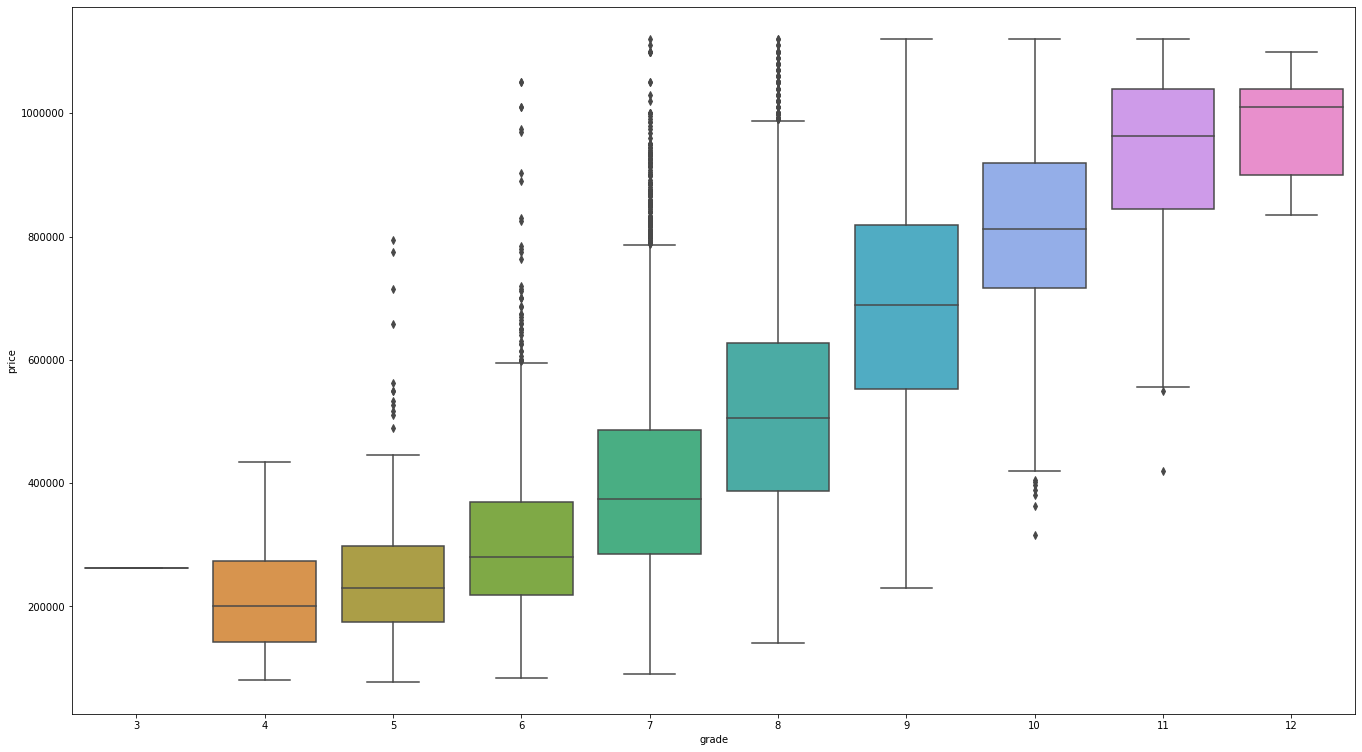

In [68]:
plt.figure(figsize=(23, 13))
fig = sns.boxplot(x="grade", y="price", data=c_data)

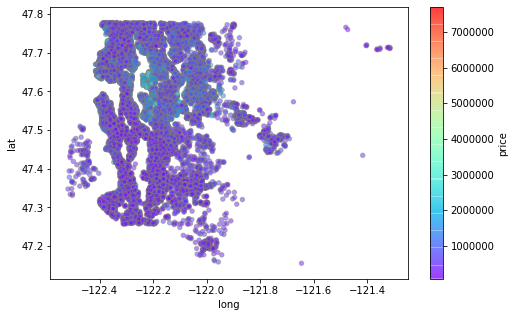

In [73]:
# Color coded plot of homes by price and location
df.plot(kind='scatter', x='long', y='lat', alpha=0.5, figsize=(8,5), 
        c='price', cmap='rainbow', colorbar=True, sharex=False, edgecolors='gray');